## Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
import random

from glob import glob
import cv2
from pathlib import Path
import os
from sklearn.metrics import classification_report

In [2]:
train_df = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv')
train_annot = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv')

In [3]:
from pathlib import Path

path = Path('/projects/sc73/ranzcr-clip-catheter-line-classification/train')

def add_path(row):

    row['image_path'] = str(path / (row['StudyInstanceUID'] + '.jpg'))
    return row

train_df = train_df.apply(add_path, axis=1)

## Pre-processing

In [4]:
# creates a function that displays one or more images
def display_image(paths):
  if type(paths) == str:
    image = cv2.imread(paths)
    plt.imshow(image)
    plt.figsize=(4,4)
    plt.show()

  elif type(paths) == pd.Series:
    paths = paths.tolist()

    image = []
    for path in paths:
      image.append(cv2.imread(path))

    fig, ax = plt.subplots(len(paths),1, figsize=(4,4))
    for i in range(len(paths)):
      ax[i].imshow(image[i])

    plt.tight_layout()
    plt.show()

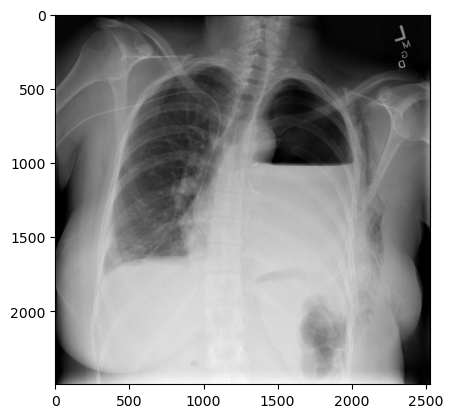

In [5]:
display_image(train_df['image_path'][2])

In [6]:
def save_overlay_annot(StudyInstanceUID):
  cmap = {'CVC - Normal':'mediumslateblue',
          'CVC - Borderline':'deeppink',
          'NGT - Normal':'greenyellow',
          'ETT - Normal':'lightseagreen',
          'CVC - Abnormal':'lawngreen',
          'ETT - Borderline':'orange',
          'Swan Ganz Catheter Present':'indianred',
          'NGT - Borderline':'yellow',
          'NGT - Abnormal':'deepskyblue',
          'ETT - Abnormal':'aquamarine',
          'NGT - Incompletely Imaged':'purple'}

  annot = train_annot[train_annot['StudyInstanceUID'] == StudyInstanceUID]
  image = cv2.imread(train_df[train_df['StudyInstanceUID'] == StudyInstanceUID]['image_path'].values[0])
  height, width, _ = image.shape
  dpi=100
  plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)

  labels_added = set()

  for i in range(len(annot)):
    points = np.array(ast.literal_eval(annot.iloc[i]['data']))
    x = points[:, 0]
    y = points[:, 1]
    label = annot.iloc[i]['label']

    plt.plot(x, y, color=cmap[annot.iloc[i]["label"]], linestyle='-')

  plt.imshow(image)
  plt.axis('off')
  plt.savefig(f'/fs03/sc73/Shekinah Robins/train_imgs2/{StudyInstanceUID}.jpg', bbox_inches='tight', pad_inches=0)
  plt.close()

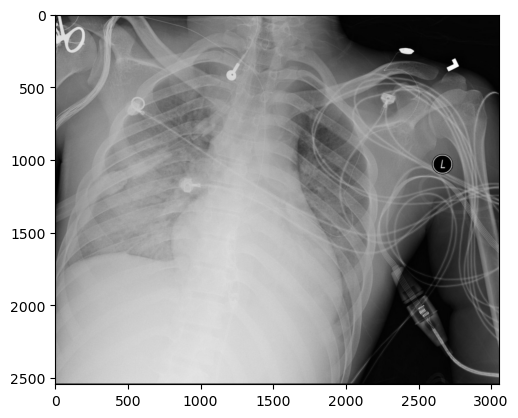

In [7]:
columns_to_check = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged',
    'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline',
    'CVC - Normal', 'Swan Ganz Catheter Present'
]

train_df_all_zeros = train_df[train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

display_image(train_df_all_zeros['image_path'][2])

In [8]:
train_df = train_df[~train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

train_df = train_df[train_df['NGT - Incompletely Imaged'] == 0]
train_df = train_df.drop(columns=['NGT - Incompletely Imaged'])

train_df = train_df[train_df['Swan Ganz Catheter Present'] == 0]
train_df = train_df.drop(columns=['Swan Ganz Catheter Present'])
train_df.shape

(26752, 12)

## Model Pre-Processing

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import resample
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.regularizers import l2

2024-10-15 14:50:11.440678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 14:50:11.961211: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [10]:
tube_classifying = train_df.copy()

def cvc_exists(row):
    if row['CVC - Abnormal'] == 1 or row['CVC - Borderline'] == 1 or row['CVC - Normal'] == 1:
        return '1'
    else:
        return '0'

def ett_exists(row):
    if row['ETT - Abnormal'] == 1 or row['ETT - Borderline'] == 1 or row['ETT - Normal'] == 1:
        return '1'
    else:
        return '0'
        
def ngt_exists(row):
    if row['NGT - Abnormal'] == 1 or row['NGT - Borderline'] == 1 or row['NGT - Normal'] == 1:
        return '1'
    else:
        return '0'

tube_classifying['CVC'] = tube_classifying.apply(cvc_exists, axis=1)  
tube_classifying['ETT'] = tube_classifying.apply(ett_exists, axis=1)  
tube_classifying['NGT'] = tube_classifying.apply(ngt_exists, axis=1)  

In [11]:
tube_classifying.head(2)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,PatientID,image_path,CVC,ETT,NGT
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,1,0,0,0,ec89415d1,/projects/sc73/ranzcr-clip-catheter-line-class...,0,0,1
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,1,0,3fc1c97e5,/projects/sc73/ranzcr-clip-catheter-line-class...,1,0,0


In [16]:
e = tube_classifying['ETT'].value_counts()

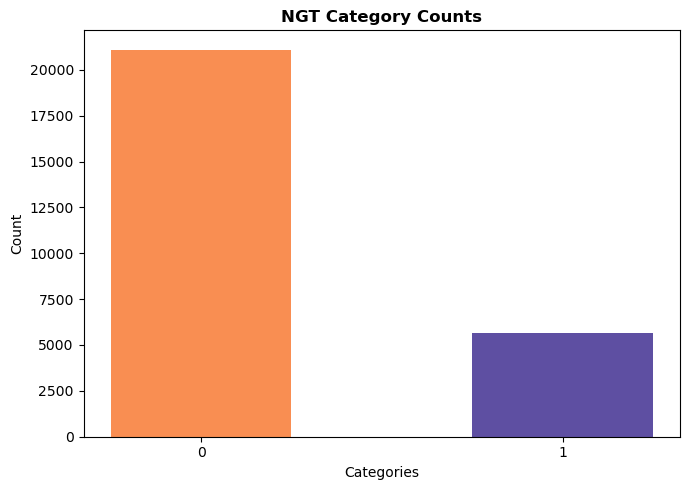

In [19]:
plt.figure(figsize=(7, 5))

# Generate colors
colors = plt.cm.Spectral(np.linspace(0.25, 1, len(e)))  

# Create the bar chart
plt.bar(e.index.astype(str), e.values, color=colors, width=0.5)  

# Set labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('NGT Category Counts', fontweight='bold')
plt.tight_layout()  
plt.show()

## Tube Classification Models

In [20]:
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True, min_delta=0.0001, monitor = "val_accuracy")

def checkpoint_cb(filepath, monitor='val_accuracy', save_best_only=True, mode='max'):

    checkpoint_cb = ModelCheckpoint(
        filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        mode=mode,
        verbose=1
    )
    return checkpoint_cb

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        layer.trainable = True
            
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
def build_model(base_model, num_classes=1):
    x = GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1000, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = layers.Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### Classifying ETT Tubes

In [22]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(tube_classifying, test_size=0.2, random_state=42)

train_data['ETT'].value_counts()

ETT
0    16886
1     4515
Name: count, dtype: int64

In [23]:
ett_majority = train_data[train_data['ETT'] == '0'].sample(4515)
ett_minority = train_data[train_data['ETT'] == '1']

ett_ds = pd.concat([ett_minority, ett_majority])
ett_ds= ett_ds.sample(frac=1, random_state=40).reset_index(drop=True)
ett_ds['ETT'].value_counts()

ETT
0    4515
1    4515
Name: count, dtype: int64

In [24]:
datagen_ett = ImageDataGenerator(dtype='float32',
                                 preprocessing_function=preprocess_input, 
                                 validation_split=0.2,
                                 rotation_range=20,
                                 fill_mode='nearest'
                                )
test_datagen_ett = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator_ett = datagen_ett.flow_from_dataframe(
    dataframe=ett_ds,
    x_col='image_path',       
    y_col='ETT',      
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',    
    subset='training',
    shuffle=True
)

val_generator_ett = datagen_ett.flow_from_dataframe(
    dataframe=ett_ds,
    x_col='image_path',         
    y_col='ETT',       
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle = True
)

test_generator_ett = test_datagen_ett.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',         
    y_col='ETT',  
    target_size=(280,280),
    batch_size=32,
    class_mode='binary', 
    shuffle=False  
)

Found 7224 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.
Found 5351 validated image filenames belonging to 2 classes.


In [25]:
res_net_base_ett = ResNet50(weights='imagenet', include_top=False, input_shape=(280,280,3))

for layer in res_net_base_ett.layers:
  layer.trainable = False
    
res_ett = build_model(res_net_base_ett)

history_res_ett = res_ett.fit(
    train_generator_ett,
    validation_data=val_generator_ett,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('res_ett_us3.h5')]
)

2024-10-15 14:52:09.217971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 14:52:09.371814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


Epoch 1/10


2024-10-15 14:52:16.823689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-15 14:52:17.252789: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-10-15 14:52:17.254386: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-10-15 14:52:17.254395: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-10-15 14:52:17.254437: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

  2/226 [..............................] - ETA: 11s - loss: 3.4447 - accuracy: 0.4531  

2024-10-15 14:52:18.601653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


226/226 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.7953
Epoch 1: val_accuracy improved from -inf to 0.82115, saving model to res_ett_us3.h5
226/226 [==============================] - 401s 2s/step - loss: 0.4888 - accuracy: 0.7953 - val_loss: 0.4123 - val_accuracy: 0.8212
Epoch 2/10
226/226 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8281
Epoch 2: val_accuracy improved from 0.82115 to 0.85105, saving model to res_ett_us3.h5
226/226 [==============================] - 239s 1s/step - loss: 0.3949 - accuracy: 0.8281 - val_loss: 0.3451 - val_accuracy: 0.8511
Epoch 3/10
226/226 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8371
Epoch 3: val_accuracy improved from 0.85105 to 0.85548, saving model to res_ett_us3.h5
226/226 [==============================] - 238s 1s/step - loss: 0.3823 - accuracy: 0.8371 - val_loss: 0.3461 - val_accuracy: 0.8555
Epoch 4/10
226/226 [==============================] - ETA: 0s - loss:

In [27]:
unfreeze_model(res_ett)

history_res_ett_tuned = res_ett.fit(
    train_generator_ett,
    validation_data=val_generator_ett,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('res_ett_us3.h5')]
)

Epoch 1/10
226/226 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8695
Epoch 1: val_accuracy improved from -inf to 0.87099, saving model to res_ett_us3.h5
226/226 [==============================] - 243s 1s/step - loss: 0.3190 - accuracy: 0.8695 - val_loss: 0.3105 - val_accuracy: 0.8710
Epoch 2/10
226/226 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8798
Epoch 2: val_accuracy improved from 0.87099 to 0.87763, saving model to res_ett_us3.h5
226/226 [==============================] - 239s 1s/step - loss: 0.2946 - accuracy: 0.8798 - val_loss: 0.2882 - val_accuracy: 0.8776
Epoch 3/10
226/226 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8949
Epoch 3: val_accuracy improved from 0.87763 to 0.89092, saving model to res_ett_us3.h5
226/226 [==============================] - 240s 1s/step - loss: 0.2640 - accuracy: 0.8949 - val_loss: 0.2696 - val_accuracy: 0.8909
Epoch 4/10
226/226 [==============================] - ETA:

In [28]:
acc = history_res_ett.history['accuracy']
val_acc = history_res_ett.history['val_accuracy']

loss = history_res_ett.history['loss']
val_loss = history_res_ett.history['val_loss']

acc += history_res_ett_tuned.history['accuracy']
val_acc += history_res_ett_tuned.history['val_accuracy']

loss += history_res_ett_tuned.history['loss']
val_loss += history_res_ett_tuned.history['val_loss']

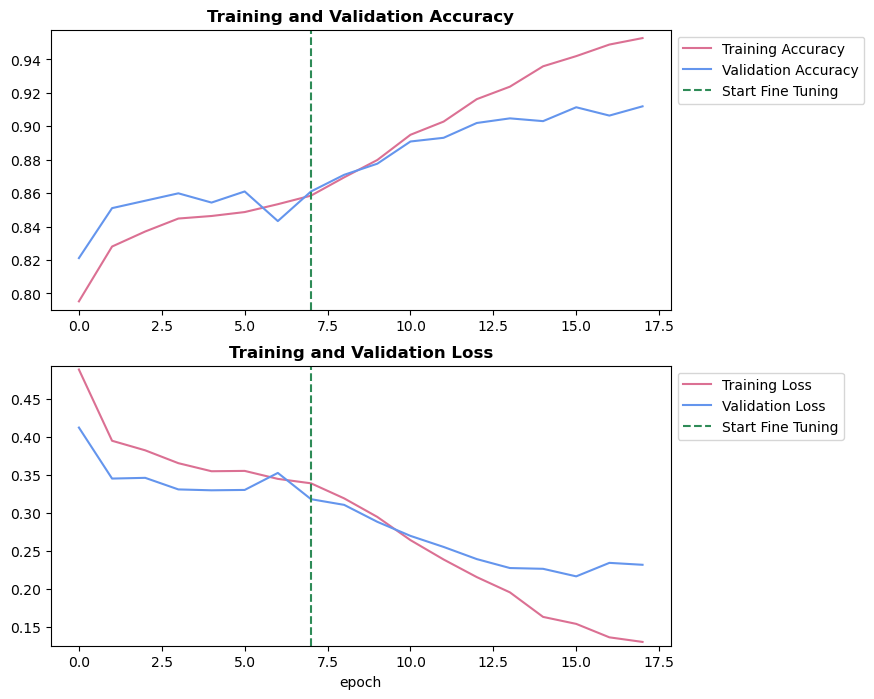

In [32]:
initial_epochs = len(history_res_ett.history['accuracy'])

acc_min = min(min(acc), min(val_acc)) - 0.005
acc_max = max(max(acc), max(val_acc)) + 0.005
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'palevioletred')
plt.plot(val_acc, label='Validation Accuracy', color='cornflowerblue')
plt.ylim([acc_min, acc_max])
plt.plot([8-1,8-1],
          plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Accuracy', fontweight = 'bold')

loss_min = min(min(loss), min(val_loss)) - 0.005
loss_max = max(max(loss), max(val_loss)) + 0.005
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'palevioletred')
plt.plot(val_loss, label='Validation Loss', color='cornflowerblue' )
plt.ylim([loss_min, loss_max])
plt.plot([8-1,8-1],
         plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('epoch')

plt.savefig('acc_loss_res_ett.png', dpi=300, bbox_inches='tight')
plt.show()

168/168 [==============================] - 188s 1s/step


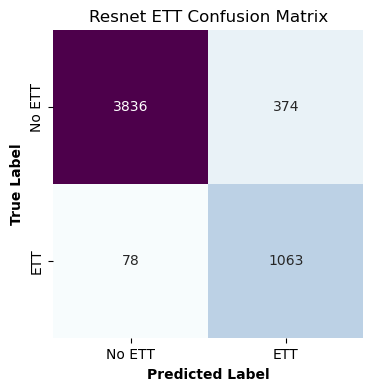

In [30]:
class_names = ['No ETT','ETT']
y_true_resett = test_generator_ett.classes
y_pred_resett = np.round(res_ett.predict(test_generator_ett))
cm = confusion_matrix(y_true_resett, y_pred_resett)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
             xticklabels=class_names,  
             yticklabels=class_names)  
plt.title('Resnet ETT Confusion Matrix')
plt.xlabel('Predicted Label', fontweight = 'bold')
plt.ylabel('True Label', fontweight = 'bold')
plt.savefig('conf_matrix_resett_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
report = classification_report(y_true_resett, y_pred_resett, target_names=class_names)  
print(report)

              precision    recall  f1-score   support

      No ETT       0.98      0.91      0.94      4210
         ETT       0.74      0.93      0.82      1141

    accuracy                           0.92      5351
   macro avg       0.86      0.92      0.88      5351
weighted avg       0.93      0.92      0.92      5351



#### Classifying NGT Tubes

In [35]:
train_data['NGT'].value_counts()


NGT
0    17267
1     4134
Name: count, dtype: int64

In [36]:
ngt_majority = train_data[train_data['NGT'] == '0'].sample(4134)
ngt_minority = train_data[train_data['NGT'] == '1']

ngt_ds = pd.concat([ngt_minority, ngt_majority])
ngt_ds= ngt_ds.sample(frac=1, random_state=40).reset_index(drop=True)
ngt_ds['NGT'].value_counts()

NGT
0    4134
1    4134
Name: count, dtype: int64

In [37]:
datagen_ngt = ImageDataGenerator(dtype='float32',
                                 preprocessing_function=preprocess_input, 
                                 validation_split=0.2,
                                 rotation_range=20,
                                 fill_mode='nearest'
                                )
test_datagen_ngt = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator_ngt = datagen_ngt.flow_from_dataframe(
    dataframe=ngt_ds,
    x_col='image_path',       
    y_col='NGT',      
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',    
    subset='training',
    shuffle=True
)

val_generator_ngt = datagen_ngt.flow_from_dataframe(
    dataframe=ngt_ds,
    x_col='image_path',         
    y_col='NGT',       
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle = True
)

test_generator_ngt = test_datagen_ngt.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',         
    y_col='NGT',  
    target_size=(280,280),
    batch_size=32,
    class_mode='binary', 
    shuffle=False  
)

Found 6615 validated image filenames belonging to 2 classes.
Found 1653 validated image filenames belonging to 2 classes.
Found 5351 validated image filenames belonging to 2 classes.


In [ ]:
res_net_base_ngt = ResNet50(weights='imagenet', include_top=False, input_shape=(280,280,3))

for layer in res_net_base_ngt.layers:
  layer.trainable = False
    
res_ngt = build_model(res_net_base_ngt)

history_res_ngt = res_ngt.fit(
    train_generator_ngt,
    validation_data=val_generator_ngt,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('res_ngt.h5')]
)

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.7782
Epoch 1: val_accuracy improved from -inf to 0.83243, saving model to res_ngt.h5
207/207 [==============================] - 307s 1s/step - loss: 0.5063 - accuracy: 0.7782 - val_loss: 0.4047 - val_accuracy: 0.8324
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8104
Epoch 2: val_accuracy improved from 0.83243 to 0.84029, saving model to res_ngt.h5
207/207 [==============================] - 219s 1s/step - loss: 0.4291 - accuracy: 0.8104 - val_loss: 0.3831 - val_accuracy: 0.8403
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8200
Epoch 3: val_accuracy did not improve from 0.84029
207/207 [==============================] - 221s 1s/step - loss: 0.4076 - accuracy: 0.8200 - val_loss: 0.4026 - val_accuracy: 0.8288
Epoch 4/10
 36/207 [====>.........................] - ETA: 2:23 - loss: 0.4176 - accuracy: 0.8180

In [ ]:
unfreeze_model(res_ngt)

history_res_ngt_tuned = res_ngt.fit(
    train_generator_ngt,
    validation_data=val_generator_ngt,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('res_ngt.h5')]
)

In [ ]:
acc = history_res_ngt.history['accuracy']
val_acc = history_res_ngt.history['val_accuracy']

loss = history_res_ngt.history['loss']
val_loss = history_res_ngt.history['val_loss']

acc += history_res_ngt_tuned.history['accuracy']
val_acc += history_res_ngt_tuned.history['val_accuracy']

loss += history_res_ngt_tuned.history['loss']
val_loss += history_res_ngt_tuned.history['val_loss']

In [ ]:
initial_epochs = len(history_res_ngt.history['accuracy'])

acc_min = min(min(acc), min(val_acc)) - 0.005
acc_max = max(max(acc), max(val_acc)) + 0.005
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'palevioletred')
plt.plot(val_acc, label='Validation Accuracy', color='cornflowerblue')
plt.ylim([acc_min, acc_max])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Accuracy', fontweight = 'bold')

loss_min = min(min(loss), min(val_loss)) - 0.005
loss_max = max(max(loss), max(val_loss)) + 0.005
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'palevioletred')
plt.plot(val_loss, label='Validation Loss', color='cornflowerblue' )
plt.ylim([loss_min, loss_max])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('epoch')

plt.savefig('acc_loss_res_ngt_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
class_names = ['No NGT','NGT']
y_true_resngt = val_generator_ngt.classes
y_pred_resngt = np.round(res_ngt.predict(val_generator_ngt))
cm = confusion_matrix(y_true_resngt, y_pred_resngt)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
             xticklabels=class_names,  
             yticklabels=class_names)  
plt.title('Resnet NGT Confusion Matrix')
plt.xlabel('Predicted Label', fontweight = 'bold')
plt.ylabel('True Label', fontweight = 'bold')
plt.savefig('conf_matrix_resngt_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
report = classification_report(y_true_resngt, y_pred_resngt, target_names=class_names)  
print(report)

## Explainable AI

In [ ]:
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [ ]:
# def lime_explainer(img, model, title):
#     explainer = lime_image.LimeImageExplainer()
#     explanation = explainer.explain_instance(img, model.predict, top_labels=1, hide_color=0, num_samples=2000)
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)
    
#     plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#     plt.axis('off')
#     plt.title("LIME Explanation for Class {}".format(top_label))
#     plt.show()